In [1]:
import fio.database
import mip

db = fio.database.load_db("data/angels-bobs.json")

print(db.keys())

dict_keys(['assemblers', 'items', 'miners', 'modules', 'recipes', 'resources', 'versions'])


In [2]:
import functools

@functools.lru_cache(64)
def get_assembly_machines(category, craftable_only=True):
  ms = []

  for m in db.assemblers.find(f""".[] | select(.crafting_categories | contains(["{category}"]))"""):
    ms.append(m)

  return ms

recipes = fio.database.HyperDiGraph()

ignore_machines = []

for r in db.recipes.find(".[]"):
    for m in get_assembly_machines(r['category']):

        if m["name"] in ignore_machines:
            continue

        A = {i["name"] for i in r["ingredients"]}
        B = {p["name"] for p in r["products"]}
        recipes.add_edge(A, B, {"recipe": r, "machine": m, "name": f"{r['name']}#{m['name']}"})


In [3]:
import json
from collections import defaultdict

# Load a sample JSON file
with open('data/base.json', 'r') as json_file:
    data = json.load(json_file)



# Analyze the JSON data
def analyze_json(json_data, output=None, parent_key=[]):
    if output is None:
        output = defaultdict(set)
    if isinstance(json_data, dict):
        for key, value in json_data.items():
            new_key = parent_key + [key]
            analyze_json(value, output, parent_key=new_key)
    elif isinstance(json_data, list):
        for item in json_data:
            analyze_json(item, output, parent_key=parent_key)
    else:
        output[tuple(parent_key)].add(type(json_data))
    
    return output

# Call the analyze_json function on the JSON data
analyze_json(data)

defaultdict(set,
            {('assemblers', 'allowed_effects', 'consumption'): {bool},
             ('assemblers', 'allowed_effects', 'pollution'): {bool},
             ('assemblers', 'allowed_effects', 'productivity'): {bool},
             ('assemblers', 'allowed_effects', 'speed'): {bool},
             ('assemblers', 'crafting_categories'): {str},
             ('assemblers', 'crafting_speed'): {float, int},
             ('assemblers', 'ingredient_count'): {int},
             ('assemblers', 'module_inventory_size'): {int},
             ('assemblers', 'name'): {str},
             ('items', 'name'): {str},
             ('items', 'stack_size'): {int},
             ('items', 'type'): {str},
             ('miners', 'allowed_effects', 'consumption'): {bool},
             ('miners', 'allowed_effects', 'pollution'): {bool},
             ('miners', 'allowed_effects', 'productivity'): {bool},
             ('miners', 'allowed_effects', 'speed'): {bool},
             ('miners', 'mining_speed'): 

In [4]:
import fio.flow


source = dict(**{resource: float("+inf") for resource in db.resources.query("map(.products[].name) | unique")})

target = {
    k: 1 for k in {
        # 'basic-tech-card',
        # 'advanced-tech-card',
        # 'automation-science-pack',
        # 'biters-research-data',
        # 'chemical-science-pack',
        # 'logistic-science-pack',
        # 'production-science-pack',
        # 'utility-science-pack',
        # 'matter-research-data',
        # 'matter-tech-card',
        # 'military-science-pack',
        # 'singularity-tech-card',
        # "logistic-science-pack"
        "advanced-logistic-science-pack",
        "alien-science-pack",
        "alien-science-pack-blue",
        "alien-science-pack-green",
        "alien-science-pack-orange",
        "alien-science-pack-purple",
        "alien-science-pack-red",
        "alien-science-pack-yellow",
        "automation-science-pack",
        "chemical-science-pack",
        "logistic-science-pack",
        "military-science-pack",
        "production-science-pack",
        "science-pack-gold",
        "space-science-pack",
        "steam-science-pack",
        "utility-science-pack",

    }
}

print(source)

model = fio.flow.optimize_model(recipes, dict(**source, **{k: -v for k, v in target.items()}))

print(model["status"])
# model = build_detailed_graph(model)

{'angels-ore1': inf, 'angels-ore2': inf, 'angels-ore3': inf, 'angels-ore4': inf, 'angels-ore5': inf, 'angels-ore6': inf, 'coal': inf, 'gas-natural-1': inf, 'liquid-multi-phase-oil': inf, 'thermal-water': inf, 'water': inf}
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Clp0024I Matrix will be packed to eliminate 141 small elements
Coin0506I Presolve 7280 (-9159) rows, 12366 (-16586) columns and 31965 (-56050) elements
Clp1000I sum of infeasibilities 16.356 - average 0.00224671, 7200 fixed columns
Coin0507I Presolve determined that the problem was infeasible with tolerance of 1e-08
Clp0029I End of values pass after 5061 iterations
Clp0014I Perturbing problem by 0.001% of 5.5758274 - largest nonzero change 0 ( 0%) - largest zero change 2.9996244e-05
Clp0000I Optimal - objective value 1740.1407
Clp0000I Optimal - objective value 1740.1407
Clp0000I Optimal - objective value 1740.1

In [5]:

from collections import defaultdict, namedtuple

inputs = defaultdict(float)
outputs = defaultdict(float)
c = defaultdict(int)


flows = []
i = 0


from uuid import uuid4

Cell = namedtuple("Cell", ["id", "recipe", "machine", "intergral", "fractional"])

class unique:
  def __init__(self):
    self.c = defaultdict(int)
  def __call__(self, i):
    r = self.c[i]
    self.c[i] += 1
    return f"id_{i}_{r}"

unique_id = unique()

import networkx as nx
graph = nx.DiGraph()

per_rows = 4
for r, m, k, f in [tuple(k.split("#") + list(v)) for k, v in model["flow"].items()]:
    c[m] += k

    r = db.recipes.query(f"""map( select(.name == "{r}"))""")[0]

    m1 = db.assemblers.query(f"""map( select(.name == "{m}")) """)
    # m2 = db.furnace.query(f"""map( select(.name == "{m}")) """)
    m = (m1)[0]

    for _ in range(k-1):
      i = unique_id(r["name"])
      flows.append(Cell(i, r, m, 1, 1))
      graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=1)

    assert f-k+1 > 0
    i = unique_id(r["name"])
    flows.append(Cell(i, r, m, 1, f-k+1))
    graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=f-k+1)

c

defaultdict(int,
            {'electronics-machine-3': 78,
             'assembling-machine-6': 253,
             'algae-farm-4': 17,
             'hydro-plant-2': 1,
             'hydro-plant-3': 32,
             'pellet-press-4': 7,
             'induction-furnace-4': 25,
             'induction-furnace-3': 2,
             'angels-chemical-plant-4': 123,
             'strand-casting-machine-4': 21,
             'casting-machine-4': 5,
             'sintering-oven-5': 17,
             'angels-electric-boiler-3': 1,
             'centrifuge-3': 1,
             'ore-sorting-facility-4': 27,
             'ore-crusher-3': 38,
             'ore-floatation-cell-3': 8,
             'crystallizer-3': 36,
             'ore-powderizer-3': 2,
             'ore-processing-machine-4': 26,
             'air-pump-4': 4,
             'electric-furnace-3': 1,
             'electrolyser-5': 13,
             'powder-mixer-4': 9,
             'blast-furnace-4': 30,
             'angels-chemical-furnace-4

# Second step.


We now need to know how many machines are needed for which exchange. To do so, we build an other linear program, with pack bins everywhere.




# Bin packing

Inputs:
* $v[j]$ output flow required
* $u[i]$ input flow required

Variables:
* $x[i, j]$ real between 0 and 1, indicate the flow from $i$ to j$
* $y[i, j]$ boolean indicate if the edge from $i$ to $j$

Minimize $\displaystyle \sum_{i, j} y[i, j]$
Subject:
* $\displaystyle \forall i j, x[i, j] \leq y[i, j]$
* $\displaystyle \forall i, \sum_j x[i, j] = u_i$
* $\displaystyle \forall j, \sum_i x[i, j] = v_j$




In [6]:
import fio.binpacking
import fio.flow
from fractions import Fraction

items = set()

flow_in = defaultdict(list)
flow_out = defaultdict(list)
for f in flows:

  ing = {k: v*f.fractional for k, v in fio.flow.ingredients_coefs(f.recipe, f.machine).items()}
  pro = {k: v*f.fractional for k, v in fio.flow.products_coefs(f.recipe, f.machine).items()}

  for i, q in ing.items():
    q = Fraction(q).limit_denominator()
    assert q >= 0
    flow_in[i].append((f.id, q))
  for i, q in pro.items():
    q = Fraction(q).limit_denominator()
    assert q >= 0
    flow_out[i].append((f.id, q))


for i in set(flow_in.keys()) | set(flow_out.keys()):
  a = sum(q for _, q in flow_in[i])
  b = sum(q for _, q in flow_out[i])
  if a > b:
    j = unique_id("sink")
    graph.add_node(j, kind="sink")
    flow_out[i].append(((j), a - b))
  elif b > a:
    j = unique_id("source")
    graph.add_node(j, kind="source")
    flow_in[i].append(((j), b - a))


assert set(flow_in.keys()) == set(flow_out.keys())

[{'amount': 1, 'name': 'advanced-circuit', 'type': 'item'}]
[{'amount': 1, 'name': 'advanced-circuit', 'type': 'item'}]
[{'amount': 1, 'name': 'advanced-circuit', 'type': 'item'}]
[{'amount': 1, 'name': 'advanced-circuit', 'type': 'item'}]
[{'amount': 1, 'name': 'advanced-circuit', 'type': 'item'}]
[{'amount': 1, 'name': 'advanced-circuit', 'type': 'item'}]
[{'amount': 1, 'name': 'advanced-circuit', 'type': 'item'}]
[{'amount': 1, 'name': 'advanced-circuit', 'type': 'item'}]
[{'amount': 3, 'name': 'advanced-logistic-science-pack', 'type': 'item'}]
[{'amount': 3, 'name': 'advanced-logistic-science-pack', 'type': 'item'}]
[{'amount': 1, 'name': 'advanced-processing-unit', 'type': 'item'}]
[{'amount': 50, 'name': 'algae-green', 'type': 'item'}]
[{'amount': 40, 'name': 'algae-red', 'type': 'item'}]
[{'amount': 40, 'name': 'algae-red', 'type': 'item'}]
[{'amount': 40, 'name': 'algae-red', 'type': 'item'}]
[{'amount': 40, 'name': 'algae-red', 'type': 'item'}]
[{'amount': 40, 'name': 'algae-r

In [13]:
import numpy as np

pos = None
new_graph = nx.DiGraph(graph)
for i in range(1):
  new_graph = nx.DiGraph(new_graph)

  for k in flow_in.keys():
    in_ = flow_in[k]
    out = flow_out[k]

    idxA, A = zip(*out)
    idxB, B = zip(*in_)

    pairs = fio.binpacking.optimize(
      [a / sum(A) for a in A],
      [b / sum(B) for b in B],
      weights=None if pos is None else {(i, j): np.sqrt(np.sum((pos[a] - pos[b])**2)) for i, a in enumerate(idxA) for j, b in enumerate(idxB)},
      timeout=1,
    )

    if pairs is None:
      pos = nx.spring_layoufio.binpacking.optimizet(new_graph, pos=pos)
      break

    for (i, j), f in pairs.items():
      new_graph.add_edge(idxA[i], idxB[j], w=f/A[i]*sum(A))

  pos = nx.kamada_kawai_layout(new_graph)


OptimizationStatus.NO_SOLUTION_FOUND


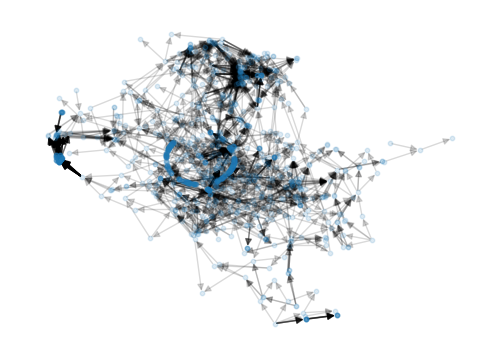

In [14]:
import random
from collections import deque
import networkx as nx

nx.draw(new_graph, pos=pos, node_size=10, alpha=.15)


In [15]:
def spiral_out_generator():
    layer = 1
    leg = 0
    x, y = 0, 0
    while True:
        yield x, y
        if leg == 0:
            x += 1
            if x == layer:
                leg += 1
        elif leg == 1:
            y += 1
            if y == layer:
                leg += 1
        elif leg == 2:
            x -= 1
            if -x == layer:
                leg += 1
        elif leg == 3:
            y -= 1
            if -y == layer:
                leg = 0
                layer += 1

def find_nearest_unoccupied_cell(i, j, occupied, k):
    spiral = spiral_out_generator()
    while True:
        ni, nj = next(spiral)
        ni, nj = i + ni, j + nj
        if 0 <= ni < k and 0 <= nj < k and (ni, nj) not in occupied:
            return ni, nj



In [16]:
import numpy as np

k = int(np.ceil(np.sqrt(len(new_graph.nodes))))



pos_int = {}

pos_a = np.array(list(pos.values()))
min_x, min_y = np.quantile(pos_a, 0.2, axis=0)
max_x, max_y = np.quantile(pos_a, 0.8, axis=0)

occupied = set()
l = list(pos.items())
random.shuffle(l)
for key, (x, y) in l:
    i = int((x-min_x)/(min_x-max_x) * k)
    j = int((y-min_y)/(min_y-max_y) * k)
    i, j = find_nearest_unoccupied_cell(i, j, occupied, k)
    occupied.add((i, j))
    pos_int[key] = np.array((i, j))


pos_random = dict()

available = [(i, j) for i in range(k) for j in range(k)]
random.shuffle(available)
for key, x in zip(pos.keys(), available):
    pos_random[key] = np.array(x)

print("found:", sum(w * np.sqrt(np.sum((pos_int[u] - pos_int[v])**2)) for u, v, w in new_graph.edges(data="w")))

print("random:", sum(w * np.sqrt(np.sum((pos_random[u] - pos_random[v])**2)) for u, v, w in new_graph.edges(data="w")))


found: 10773.022579696608
random: 14824.72266739067


In [17]:
pos_int

{'id_iron-ore-processing_2': array([0, 0]),
 'id_molten-steel-smelting-3_0': array([0, 1]),
 'id_sink_15': array([0, 2]),
 'id_fish-keeping-3_56': array([35,  0]),
 'id_angels-wire-coil-silver-converting_0': array([34,  0]),
 'id_advanced-circuit_4': array([33,  0]),
 'id_circuit-board_6': array([32,  0]),
 'id_slag-processing-8_4': array([ 0, 19]),
 'id_slag-processing-4_6': array([0, 3]),
 'id_source_66': array([0, 4]),
 'id_fish-pressing-2_28': array([23,  0]),
 'id_synthetic-wood_2': array([18,  0]),
 'id_small-alien-artifact_18': array([0, 5]),
 'id_science-pack-gold_4': array([0, 6]),
 'id_phenolic-board_1': array([31,  0]),
 'id_source_32': array([0, 7]),
 'id_rocket-control-unit_8': array([30,  0]),
 'id_alien-pre-artifact-base_21': array([1, 0]),
 'id_liquid-fish-atmosphere_4': array([0, 8]),
 'id_small-alien-artifact_2': array([0, 9]),
 'id_thermal-water-purification_14': array([ 0, 10]),
 'id_angels-solder-smelting-2_0': array([ 0, 11]),
 'id_source_45': array([ 0, 12]),
 'i

The current position seems to be good enought for actual blueprint construction using robots

# Blueprint construction

We don't need for each recipes to create a new blueprint: we only need one blueprint for each machines and fluids inputs and outputs.


In [19]:
import pandas as pd

df = {}

def select(kind1, kind2):
  return sum(1 for i in data["recipe"][kind1] if i["type"] == kind2)

for node, data in new_graph.nodes(data=True):
  if data["kind"] != "transformator":
    continue
  df[node] = {
    "machine": data["machine"]["name"],
    "recipe": data["recipe"]["name"],
    "item_in": select("ingredients", "item"),
    "item_out": select("products", "item"),
    "fluid_in": select("ingredients", "fluid"),
    "fluid_out": select("products", "fluid"),
    "data": data,
  }

df = pd.DataFrame(df).T

pd.display(df.groupby(["machine", "item_in", "item_out", "fluid_in", "fluid_out"]).count())


AttributeError: 'DataFrame' object has no attribute 'display'

In [ ]:
import fio.blueprint

with open("blueprints/automated1.json.base64") as f:
  book = fio.blueprint.loads(f.read())


book = {b["blueprint"]["label"]: b["blueprint"] for b in book["blueprint_book"]["blueprints"]}

book["f-n-n"]

In [ ]:
barrels_recipes = {k for k in db.recipe.keys() if "barrel" in k}

{k: (f"empty-{k}-barrel" in barrels_recipes and f"fill-{k}-barrel" in barrels_recipes) for k in db.fluid.keys()}

In [ ]:
fio.blueprint.loads("""0eNqVk9lug0AMRf/Fz0xUCEvLr1RRxOKA1VnozBAVRfx7DWlQ0hKhPiA8yHPuxcsFStljZ0l7yC9AldEO8vcLOGp0IadvfugQciCPCgLQhZpOH1YUXhnXtWipEnytRu3QwhgAcfwFeTgeAkDtyRNemfNhOOpelZyZh9u0ADrjGGD05IShIgzfdkkAA4dxsktYriaL1TUlDoBjmv22Q21Ng5od/VGOFuXCOVSlJN0IVVQtaRTRqmqyqKa/VdM71RNJKW7SoiysRbnmYL84UFhTrwRKxk0/3xmJqw7SxUHMDlaY8cI8Fc4LmironxQxfoA9FnEFnfwDnWz5TBeYNA05P3W8RcZ23A06o+isOVO9id+v47NneIufPb83K7KfK/KTfeSO8pXrAN8me1FA1fnh1uYAKtNPexS+jIdp+OeVye82LIAzo2bZ6DWMs7coSxN+wmwcvwHvxCnW""")